**CV2021 - week8**

**Contents**

* [Adaptive RANSAC](https://colab.research.google.com/drive/1ElcBrnM2pZVWKcMF_G0B31VPc1Ivky4i#scrollTo=FvCD4UzQxZqH&line=3&uniqifier=1)
* [Visual Words](https://colab.research.google.com/drive/1ElcBrnM2pZVWKcMF_G0B31VPc1Ivky4i#scrollTo=eNZgpiwE8wLC&line=4&uniqifier=1)
* [Bagging and boosting for shape based classification](https://colab.research.google.com/drive/1ElcBrnM2pZVWKcMF_G0B31VPc1Ivky4i#scrollTo=tXSRmvY8-z_L&line=2&uniqifier=1)
* [Adaboost](https://colab.research.google.com/drive/1ElcBrnM2pZVWKcMF_G0B31VPc1Ivky4i#scrollTo=7hdJi9PTp_Qg&line=4&uniqifier=1)


**HOMEWORK**

* **1bp** Implement histogram computation (closest centroid) and class prediction in Bag-of-Visual-words model using a *KDTree object*. Report the performance gain.

* **1bp** Using a class based visual words index, implement the Naive Bayes classification method (see the probabilistic model below). Compare the performance to the 1-NN class prediction.

* **1bp** Experiment with pooling strategies similar to the one in the EFD demo. Keep the same set of parameters for the SVC classifier. Observe the improvement in accuracy (total and per class).

* **2bp** Using the Adaboost pseudocode, propose your own Adaboost implementation for binary classification. Use a *scikit* *DecisionTree* as your base classifier, updating the set of per-sample weights at each iteration. Compare the classification accuracy with a single *DecisionTree* classifier, and a *RandomForest* of 10 estimators. Use the EFD data extracted for the third demo as your dataset.


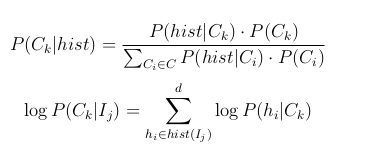

**1. Adaptive RANSAC**

This was the third task of *week 7* homework.

Considering *p* the probability of an iteration with an outlier free subset pick, we can formulate the probability of never selecting an *outlier free* subset as *1 - p*. The experiments are independent random events, and so, the probability of an outlier free subset depends on the inlier ratio *w*, the number of points needed for model estimation *n*, and the number of repetitions for the experiment *k*.

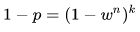


This way, we can derive the approximate number of iterations untill an *outlier free subset* as follows:

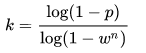

The value for *p* is usually the choice of the user, and usually used values are 98-99%.

**References**
* [MLESAC](https://www.robots.ox.ac.uk/~vgg/publications/2000/Torr00/torr00.pdf)


In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 72kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np


def normalize_points(xs):
  _, n = xs.shape
  c = np.expand_dims(np.mean(xs[:2, :], axis=1), axis=1)
  d = xs[:2, :] - np.repeat(c, n, axis=1)
  d = np.sqrt(2) / np.mean(np.sqrt(np.sum(d * d, axis=0)))
  T = np.eye(3)
  T[0, 0] = d
  T[1, 1] = d
  T[0, 2] = -d * c[0]
  T[1, 2] = -d * c[1]
  normalized_xs = T @ xs
  return normalized_xs, T

# compute the fundamental matrix using the normalized data
def compute_fundamental_matrix(x, x_prime):
  _, n = x.shape
  A = np.zeros((n, 9))
  for i in range(n):
    A[i, 0] = x[0, i] * x_prime[0, i]
    A[i, 1] = x[0, i] * x_prime[1, i]
    A[i, 2] = x[0, i]
    A[i, 3] = x[1, i] * x_prime[0, i]
    A[i, 4] = x[1, i] * x_prime[1, i]
    A[i, 5] = x[1, i]
    A[i, 6] = x_prime[0, i]
    A[i, 7] = x_prime[1, i]
    A[i, 8] = 1
  
  A = A.T @ A
  U, S, V = np.linalg.svd(A, full_matrices=True)
  V = V.T
  F = V[:, -1]
  F = F.reshape(3, 3)

  # apply the rank constraint
  U_f, S_f, V_f = np.linalg.svd(F)
  S_f = np.diag(S_f)
  S_f[2, 2] = 0
  F_h = U_f @ S_f @ V_f
  return F_h, F

In [ ]:
import math
import random


def sampson_error(F, x1s, x2s):
  _, n = x1s.shape
  x1_reprojected = F @ x1s
  x2_reprojected = F.T @ x2s

  normalizer = np.dot(x1_reprojected[0, :], x1_reprojected[0, :]) + \
                np.dot(x1_reprojected[1, :], x1_reprojected[1, :]) + \
                np.dot(x2_reprojected[0, :], x2_reprojected[0, :]) + \
                np.dot(x2_reprojected[1, :], x2_reprojected[1, :])

  dist = np.zeros(n)
  for i in range(n):
    dist[i] = x2s[:, i].T @ F @ x1s[:, i]

  error = np.divide(dist ** 2, normalizer)
  return error


def adaptive_RANSAC_fundamental_matrix(x1s, x2s):
  _, n = x1s.shape
  
  d = 5e-6
  p = 0.99

  best_inliers = None
  best_inliers_nr = 0

  it = 0
  max_iter = 1000

  while it < max_iter:
    it += 1

    idx = random.sample(range(n), 8)
    x = x1s[:, idx]
    x_prime = x2s[:, idx]
    
    Fh, F = compute_fundamental_matrix(x, x_prime)
    error = sampson_error(Fh, x1s, x2s)

    inliers_idx = np.argwhere(error < d)
    nb_inliers = inliers_idx.shape[0]
    w = nb_inliers / n
    
    # model fits the entire dataset
    if w == 1:
      break

    try:
      projected_iter = math.log(1 - p) / math.log(1 - w ** 8)
      max_iter = int(projected_iter)
    except ZeroDivisionError:
      print(nb_inliers, n)

    if nb_inliers > best_inliers_nr:
      best_inliers_nr = nb_inliers
      best_inliers = inliers_idx

  Fh, F = compute_fundamental_matrix(x1s[:, best_inliers][:, :, 0], x2s[:, best_inliers][:, :, 0])
  return Fh, F

In [ ]:
import cv2 as cv


img_left = cv.imread("/content/drive/MyDrive/CVCourse21/pics/0018.png")
img_left_gray = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
img_right = cv.imread("/content/drive/MyDrive/CVCourse21/pics/0019.png")
img_right_gray = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
kp_l, desc_l = sift.detectAndCompute(img_left_gray, None)
kp_r, desc_r = sift.detectAndCompute(img_right_gray, None)

bf_matcher = cv.BFMatcher()
matches = bf_matcher.knnMatch(desc_l, desc_r, k=2)

kept_matches = []
for m, n in matches:
  if m.distance < 0.75 * n.distance:
    kept_matches.append([m])

x1s = np.ones((3, len(kept_matches)))
x2s = np.ones((3, len(kept_matches)))

k = 0
for m in kept_matches:
  try:
    i_r = m[0].trainIdx
    i_l = m[0].queryIdx
    x1s[:2, k] = kp_l[i_l].pt
    x2s[:2, k] = kp_r[i_r].pt
    k += 1
  except IndexError:
    print((i_l, i_r))

nxs_1, T1 = normalize_points(x1s)
nxs_2, T2 = normalize_points(x2s)

Fh, F = adaptive_RANSAC_fundamental_matrix(nxs_1, nxs_2)
F = T2.T @ F @ T1
print(F) 


Inliers:  1690 (1690, 1)
Inliers:  1573 (1573, 1)
Inliers:  1630 (1630, 1)
Inliers:  1566 (1566, 1)
Inliers:  1523 (1523, 1)
Inliers:  1637 (1637, 1)
Inliers:  1628 (1628, 1)
Inliers:  1683 (1683, 1)
Inliers:  1583 (1583, 1)
Inliers:  1586 (1586, 1)
Inliers:  1679 (1679, 1)
Inliers:  1897 (1897, 1)
[[ 1.92693414e-09  9.70899574e-08 -1.19996201e-04]
 [-1.26057871e-07 -9.22296433e-09 -9.48534280e-04]
 [ 1.73733304e-04  1.05475658e-03 -1.16749449e-01]]


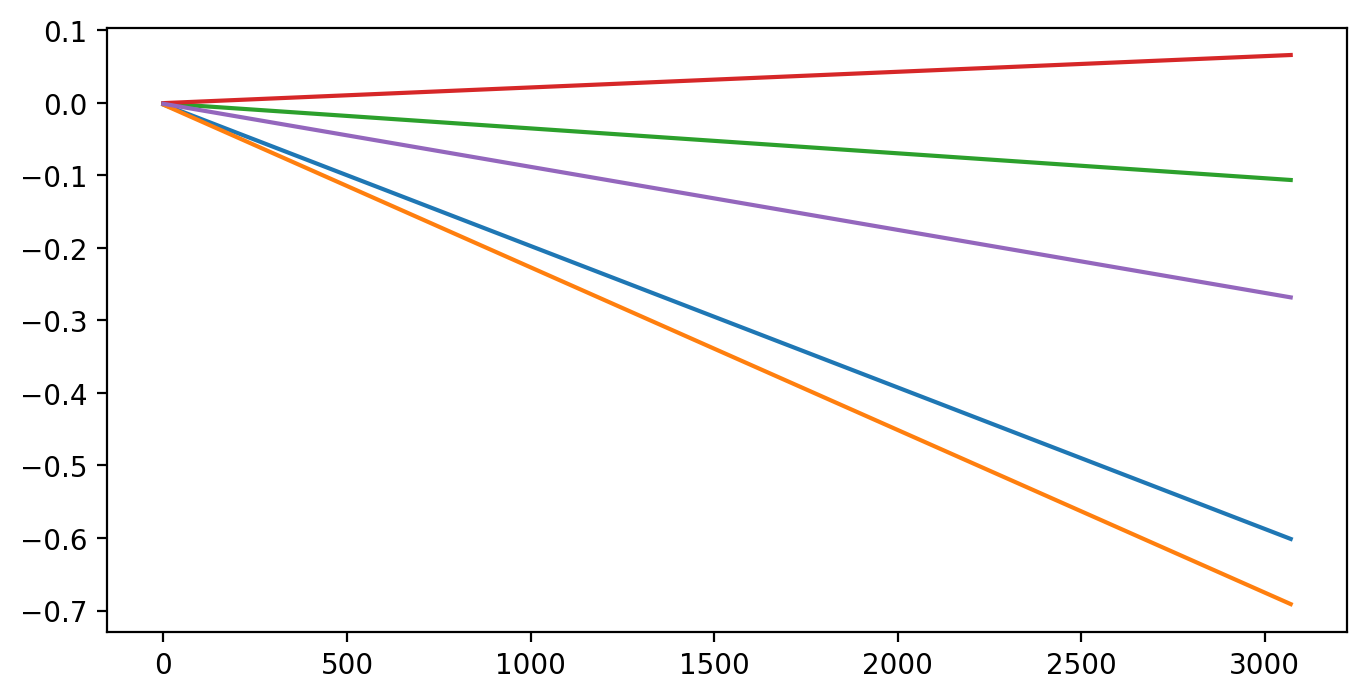

In [ ]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200


_, n = x1s.shape
idx = random.sample(range(n), 5)
X = x1s[:, idx]
lines = F @ X

for i in range(5):
  lines[:, i] = 1 / lines[2, i] * lines[:, i] 

h, w, _ = img_right.shape

for i in range(5):
  x = np.arange(w)
  y = lines[0, i] * x + lines[1, i]
  plt.plot(x, y)

**2. Visual Words and Image Retrieval**


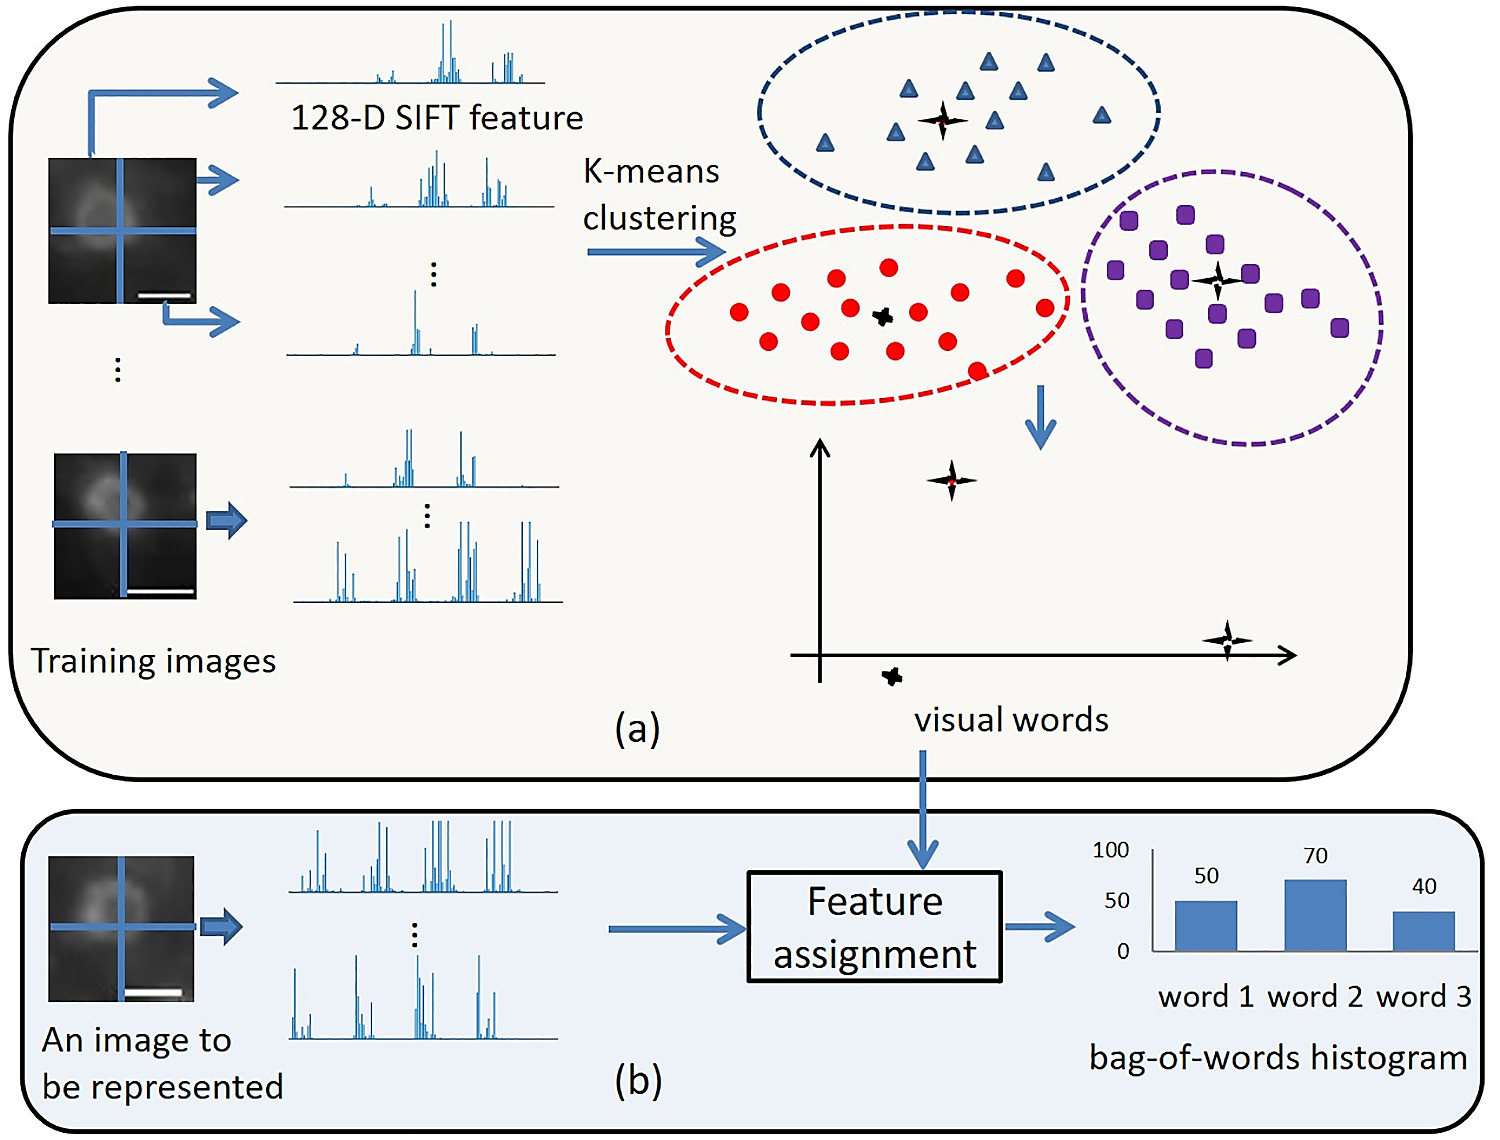

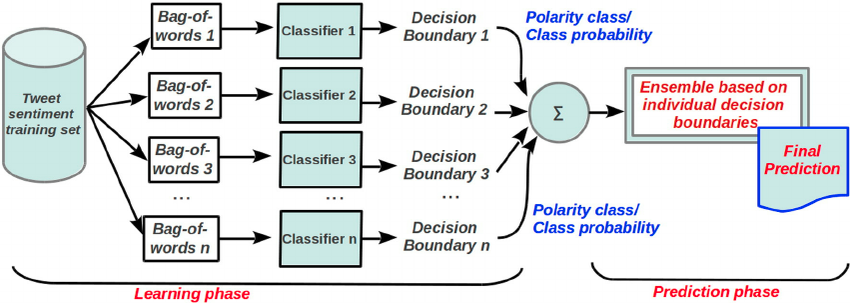

**References**

* [Bag-of-visual-words](http://vision.stanford.edu/teaching/cs131_fall1718/files/14_BoW_bayes.pdf)

* [About bag-of-words](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html)

In [2]:
import numpy as np
import cv2 as cv
import os
from scipy.spatial import distance
from sklearn.cluster import KMeans


def load_dataset(dset_dir):
  # a dict to keep the class of each image
  image_index = {}

  for class_name in os.listdir(dset_dir):
    in_cat_images = []
    cat_dir_path = "{}/{}".format(dset_dir, class_name)
    for file_name in os.listdir(cat_dir_path):
      img_path = "{}/{}".format(cat_dir_path, file_name)
      img = cv.imread(img_path, 0) # open as grayscale
      if img is not None: # unless some corrupted images
        in_cat_images.append(img)
    image_index[class_name] = in_cat_images
  
  return image_index

# iterates over the image dict and returns the raw vocabulary 
# and the vocabulary characteristic to each of the classes
def extract_features(img_dict):
  sift_descriptors = {}
  vocabulary = []

  sift = cv.SIFT_create()
  
  for img_class, img_list in img_dict.items():
    features = []
    for image in img_list:
      kp, des = sift.detectAndCompute(image, None)
      vocabulary.extend(des)
      features.append(des)
    
    # take care also for the in class vocabulary
    sift_descriptors[img_class] = features
  
  return vocabulary, sift_descriptors


# k - an integer representing the number of representative words
# vocabulary - a list of the features extracted across the train dset
def knn_refine_vocab(k, vocabulary):
  kmeans = KMeans(n_clusters=k, n_init=10)
  kmeans.fit(vocabulary)
  # return the visual words as the centroids of the clustered data
  v_words = kmeans.cluster_centers_
  return v_words


# finds the closest centroid
def find_index(feat, visual_words):
  dist_min = 0
  ind_min = 0
  dist_min = distance.euclidean(feat, visual_words[0]) 
  for i in range(1, len(visual_words)):
    dist = distance.euclidean(feat, visual_words[i]) 
    if dist < dist_min:
      ind_min = i
      dist_min = dist
  return ind_min


# uses the class sift descriptors dict and the centroids list 
# as visual words
def create_bag_of_words(sift_descriptors, v_words):
  dict_bovw = {}
  for img_class, feat_list in sift_descriptors.items():
    in_cat_feats = []
    # for each image sift returns a list of descriptors
    for feat_set in feat_list:
      histogram = np.zeros(len(v_words))
      for descriptor in feat_set:
        index = find_index(descriptor, v_words)
        histogram[index] += 1
      in_cat_feats.append(histogram)

    dict_bovw[img_class] = in_cat_feats
  
  return dict_bovw

# predict class of a test image histogram, using 1nn
def knn_predict_class(train_feats, test_feats):
  # keep information regarding each class accuracy
  class_stat = {}
  idx_test = 0
  correct = 0

  for test_class, test_descrip in test_feats.items():
    class_stat[test_class] = [0, 0] # tuple would be immutable
    for tst_des in test_descrip:
      minim = 1e6
      key = None
      for train_class, train_descrip in train_feats.items():
        for trn_des in train_descrip:
          dist = distance.euclidean(tst_des, trn_des)
          if key is None:
            # initialize with the first distance
            minim = dist
            key = train_class
          else:
            if dist < minim:
              minim = dist
              key = train_class
       
      if key == test_class:
        correct += 1
        class_stat[test_class][0] += 1 # update correct
      
      idx_test += 1
      class_stat[test_class][1] += 1 # update total

  return idx_test, correct, class_stat



def evaluate_model(result_log):
  acc = result_log[1] / result_log[0] * 100
  print("Total accuracy: {}%".format(acc))

  for class_key, class_stat in result_log[2].items():
    acc = class_stat[0] / class_stat[1] * 100
    print("Accuracy for class \"{}\": {}%".format(class_key, acc))


In [3]:
# 1. load data
train_img = load_dataset("/content/drive/MyDrive/CVCourse21/dset/train/")
test_img = load_dataset("/content/drive/MyDrive/CVCourse21/dset/test/")

In [ ]:
# 2. extract features 
train_vocab, train_class_feats = extract_features(train_img)
# test vocab MUST NOT  be used in feature designing
_, test_class_feats = extract_features(test_img)

In [ ]:
# 3. determine the visual words
visual_words = knn_refine_vocab(150, train_vocab)

In [ ]:
# 4. create bag_of_visual_word_histograms
train_bovw = create_bag_of_words(train_class_feats, visual_words)
test_bovw = create_bag_of_words(test_class_feats, visual_words)

In [ ]:
# 5. make test predictions
result_log = knn_predict_class(train_bovw, test_bovw) 

In [ ]:
print(result_log)
evaluate_model(result_log)

(99, 79, {'positive': [45, 49], 'negative': [34, 50]})
Total accuracy: 79.7979797979798%
Accuracy for class "positive": 91.83673469387756%
Accuracy for class "negative": 68.0%


**3. Shape based features for classification**

This task introduces the MNIST dataset, and the version provided has 126 per-class training samples and 20 testing samples per class. The samples are *png* grayscale images representing handwritten numerical characters. 

The task aims at experimenting with *shape-based features* and experimenting different methods of improving classification performance of weak classifiers.

**References**

* [Elliptic Fourier Descriptors](https://spatial-efd.readthedocs.io/en/latest/)
* [Short tutorial on EFD](https://3010tangents.wordpress.com/2015/05/12/elliptic-fourier-descriptors/)
* [MNIST dataset](http://yann.lecun.com/exdb/mnist/)
* [Processed MNIST (.png)](https://github.com/myleott/mnist_png)

In [4]:
from pyefd import elliptic_fourier_descriptors


# extracting and EFD feature should be done in 2 steps
# Coutours are to be detected, and then EFD is applied on contours
def extract_efd_feature(img):
  contours, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  fd = []
  for cnt in contours:
    coeffs = elliptic_fourier_descriptors(np.squeeze(cnt), order=10, normalize=True)
    fd.append(coeffs.flatten()[3:])
  return np.array(fd)


def prepare_data(image_set):
  X = []
  Y = []
  for img_class, img_list in image_set.items():
    for image in img_list:
      try:
        fdesc = extract_efd_feature(image)
        X.append(np.max(fdesc, axis=0)) # pooling strategy here (task 3)
        Y.append(int(img_class))
      except np.AxisError:
        continue # some corrupted images

  return np.array(X), np.array(Y)

In [6]:
# we will follow a similar pipeline as before experiemtning with different features 
# and classifiers

train_img = load_dataset("./mnist_png_demo/training/")
test_img = load_dataset("./mnist_png_demo/testing/")


NameError: name 'load_dataset' is not defined

In [7]:
X_train, Y_train = prepare_data(train_img)
X_test, Y_test = prepare_data(test_img)

In [8]:
print(X_train.shape)
print(Y_train.shape)

(1269, 37)
(1269,)


**Support Vectors Machine based classifier**

The used pipeline consists of a single SVC, preceded by a standard scaler. The scaler object has the task of normalizing the input data.



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# scale the input data
# DO NOT fit the testing data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf =  SVC(C=1.5, kernel='rbf', gamma='auto')
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))


NameError: name 'X_train' is not defined

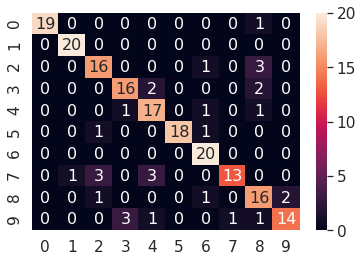

In [13]:
import pandas as pd
import seaborn as sn


clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})



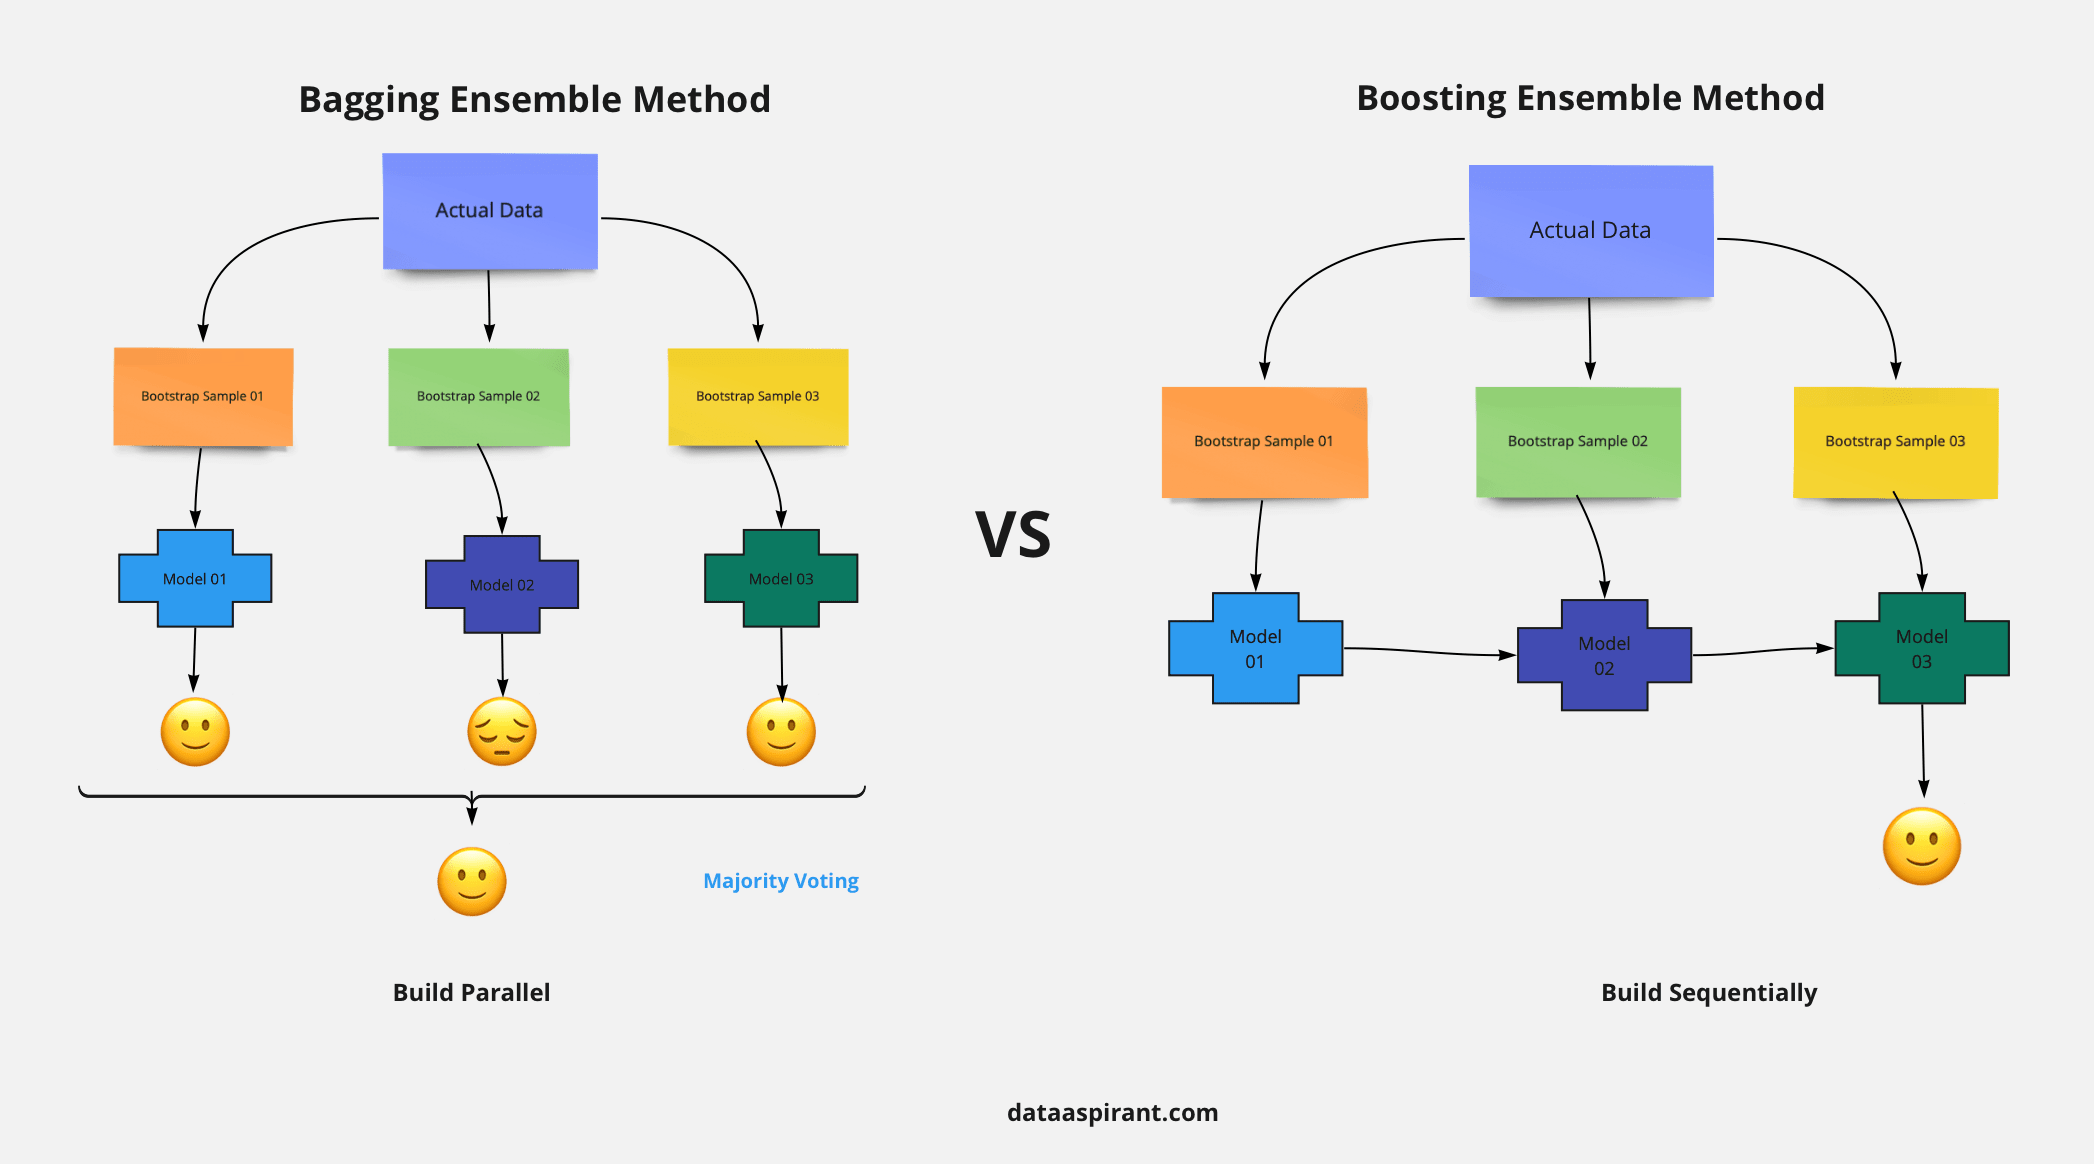

Classification accuracy: 0.86


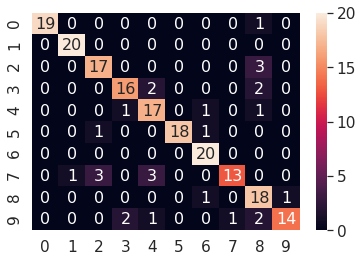

In [151]:
from sklearn.ensemble import BaggingClassifier


base_clf =  SVC(C=1.5, kernel='rbf', gamma='auto')
clf = BaggingClassifier(base_estimator=base_clf, n_estimators=20,
                        max_features=0.8, max_samples=0.9, bootstrap=True,
                        warm_start=True, random_state=0)
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})


Classification accuracy: 0.84


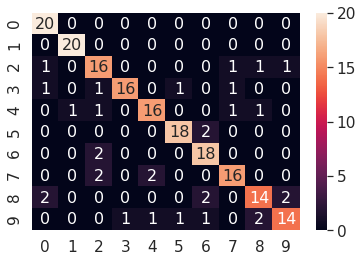

In [14]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=50,
                        max_depth=5, criterion="entropy")
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})


**4. Adaboost**


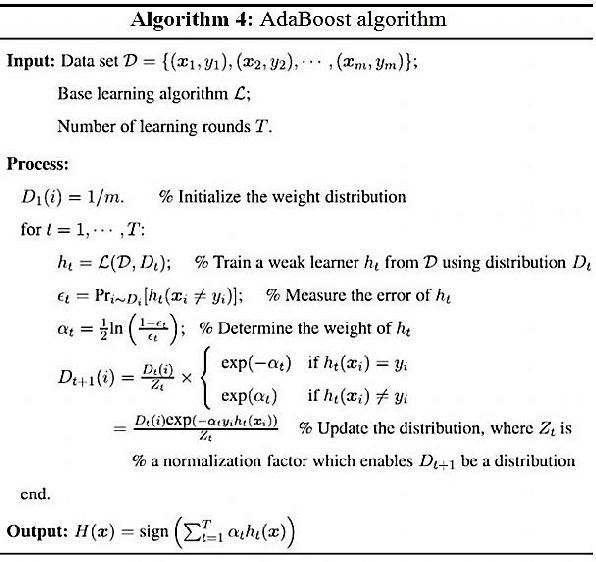

**Reference**
 * [Scikit Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

Classification accuracy: 0.725


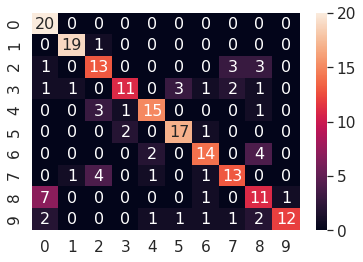

In [161]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_clf =  DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=1, random_state=0)
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})


Classification accuracy: 0.855


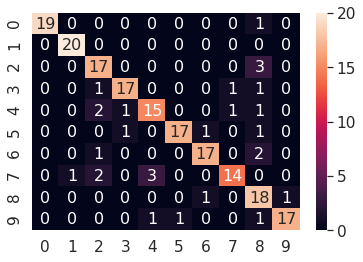

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_clf =  DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=80, random_state=0)
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]
df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16})



* **2bp** Using the Adaboost pseudocode, propose your own Adaboost implementation for binary classification. Use a *scikit* *DecisionTree* as your base classifier, updating the set of per-sample weights at each iteration. Compare the classification accuracy with a single *DecisionTree* classifier, and a *RandomForest* of 10 estimators. Use the EFD data extracted for the third demo as your dataset.

In [1]:
from sklearn.tree import DecisionTreeClassifier
class Boosting(object):

    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.N = self.X_train.shape[0]
        self.y_train = y_train
        self.weights = np.ones(self.N)/self.N
        self.epsilont = []
        self.alphas = []
        self.classifiers = []
        self.histogram = {}
        #self.num_estimators = T
        
    def doBoosting(self):
#         for t in range(self.num_estimators):
        for t in range(1500):
            output = np.random.choice(self.N, self.N, p=self.weights)
            
            for t in output:
                self.histogram[t] = self.histogram.get(t, 0) + 1
            
#             print output
            B_Xtrain = self.X_train[output]
            B_ytrain = self.y_train[output]
        
            ls = DecisionTreeClassifier()
            ls.calcLeastSquares(B_Xtrain, B_ytrain)
#             print ls.weights
            Y_pred = ls.makePredictions(self.X_train)
            
#             print Y_pred
            
            e_t = np.sum((Y_pred != self.y_train) * self.weights)
#             print e_t
            if e_t > 0.5:
                ls.weights = -ls.weights
                Y_pred = ls.makePredictions(self.X_train)
                e_t = np.sum((Y_pred != self.y_train) * self.weights)
            
#             print e_t
            self.epsilont.append(e_t)

            alpha_t = 0.5 * np.log((1 - e_t)/e_t)
            self.alphas.append(alpha_t)
            self.classifiers.append(ls)
            
#             print alpha_t   
            self.weights = self.weights * np.exp(-alpha_t* Y_pred * self.y_train)
            self.weights = self.weights / np.sum(self.weights)

In [2]:


training_error = []
testing_error = []

boost = Boosting(X_train, y_train)
boost.doBoosting()

for t in tqdm(range(1, 1501)):
    sum_train = np.zeros(X_train.shape[0])
    sum_test = np.zeros(X_test.shape[0])
    for i in range(t):
        alpha = boost.alphas[i]
        classifier = boost.classifiers[i]
#             print X_train.shape
#             print classifier.weights.shape
#             print np.dot(X_train, classifier.weights).shape
        sum_train += (alpha * classifier.makePredictions(X_train))
        sum_test += (alpha * classifier.makePredictions(X_test))
    fboost_train_pred = np.sign(sum_train)
    fboost_test_pred = np.sign(sum_test)

    training_error.append(np.sum(fboost_train_pred != y_train)/y_train.shape[0])
    testing_error.append(np.sum(fboost_test_pred != y_test)/y_test.shape[0])



NameError: name 'X_train' is not defined